## Dataset Creation 

In [1]:
import numpy as np
import torch 
from uqregressors.utils.validate_dataset import clean_dataset, validate_dataset

seed = 42 

np.random.seed(seed)
torch.manual_seed(seed)

rng = np.random.RandomState(seed)
def true_function(x):
    return np.sin(3 * np.pi * x)

X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
y_true = true_function(X_test)

X_train = np.sort(rng.rand(100, 1))
y_train = true_function(X_train).ravel() 

X_train, y_train = clean_dataset(X_train, y_train)
validate_dataset(X_train, y_train, name="Synthetic Sine")

Summary for: Synthetic Sine dataset
Number of samples: 100
Number of features: 1
Output shape: (100, 1)
Dataset validation passed.



## Plotting

In [2]:
import matplotlib.pyplot as plt

def plot_uncertainty_results(mean, lower, upper, model_name): 
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, y_true, 'g--', label="True Function")
    plt.scatter(X_train, y_train, color='black', label="Training data", alpha=0.6)
    plt.plot(X_test, mean, label="Predicted Mean", color="blue")
    plt.fill_between(X_test.ravel(), lower, upper, alpha=0.3, color="blue", label = "Uncertainty Interval")
    plt.legend()
    plt.title(f"{model_name} Uncertainty Test")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

## MC Dropout

[Logger-25496] epoch=0, train_loss=4.043066024780273
[Logger-25496] epoch=50, train_loss=0.5604311227798462
[Logger-25496] epoch=100, train_loss=0.1411677747964859
[Logger-25496] epoch=150, train_loss=0.12727274000644684
[Logger-25496] epoch=200, train_loss=0.09036372601985931
[Logger-25496] epoch=250, train_loss=0.12473150342702866
[Logger-25496] epoch=300, train_loss=0.10574949532747269
[Logger-25496] epoch=350, train_loss=0.1355348378419876
[Logger-25496] epoch=400, train_loss=0.07537278532981873
[Logger-25496] epoch=450, train_loss=0.06581668555736542
[Logger-25496] epoch=500, train_loss=0.053246647119522095
[Logger-25496] epoch=550, train_loss=0.1005968451499939
[Logger-25496] epoch=600, train_loss=0.0809686928987503
[Logger-25496] epoch=650, train_loss=0.06121738627552986
[Logger-25496] epoch=700, train_loss=0.08076824247837067
[Logger-25496] epoch=750, train_loss=0.07462842017412186
[Logger-25496] epoch=800, train_loss=0.07125332206487656
[Logger-25496] epoch=850, train_loss=0.0

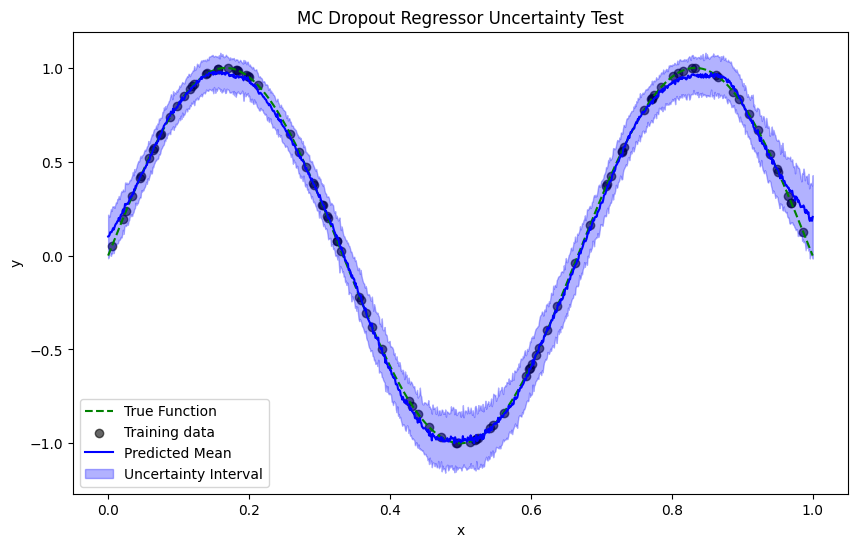

In [3]:
from uqregressors.bayesian.dropout import MCDropoutRegressor

dropout = MCDropoutRegressor(
    hidden_sizes=[100, 100],
    dropout=0.1,
    alpha=0.1,  # 90% confidence
    tau=1e6,
    tune_tau=False, 
    BO_epochs=200, 
    BO_calls=10,
    n_samples=100,
    epochs=1000,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    use_wandb=False
)

dropout.fit(X_train, y_train)
dropout_sol = dropout.predict(X_test)

plot_uncertainty_results(*dropout_sol, "MC Dropout Regressor")

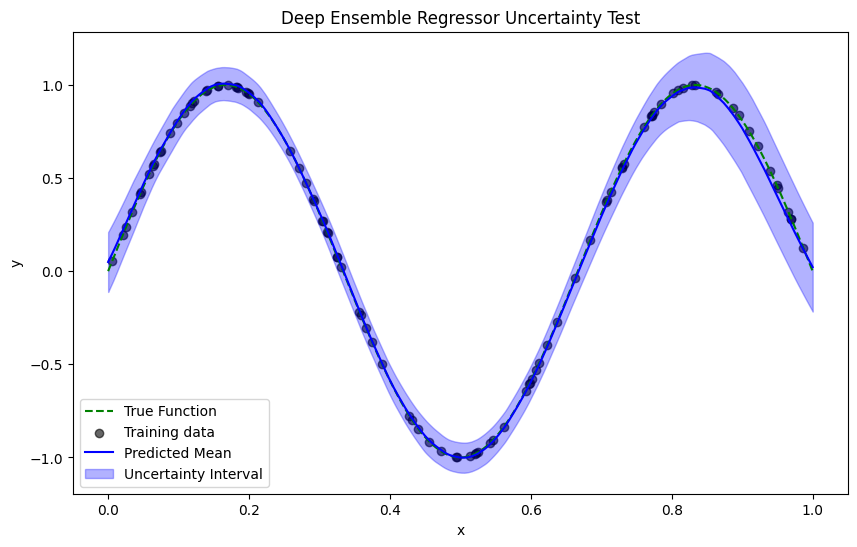

In [4]:
from uqregressors.bayesian.deep_ens import DeepEnsembleRegressor

deep_ens = DeepEnsembleRegressor(n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,  # 90% confidence
    epochs=1000,
    learning_rate=1e-3,
    device="cpu", 
    n_jobs=2,
    use_wandb=False)

deep_ens.fit(X_train, y_train)
deep_ens_sol = deep_ens.predict(X_test)

plot_uncertainty_results(*deep_ens_sol, "Deep Ensemble Regressor")

## Standard Gaussian Process Regression (GPR)

c:\Users\arsha\AppData\Local\hatch\env\virtual\uqregressors\pe5T5b9S\uqregressors\lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


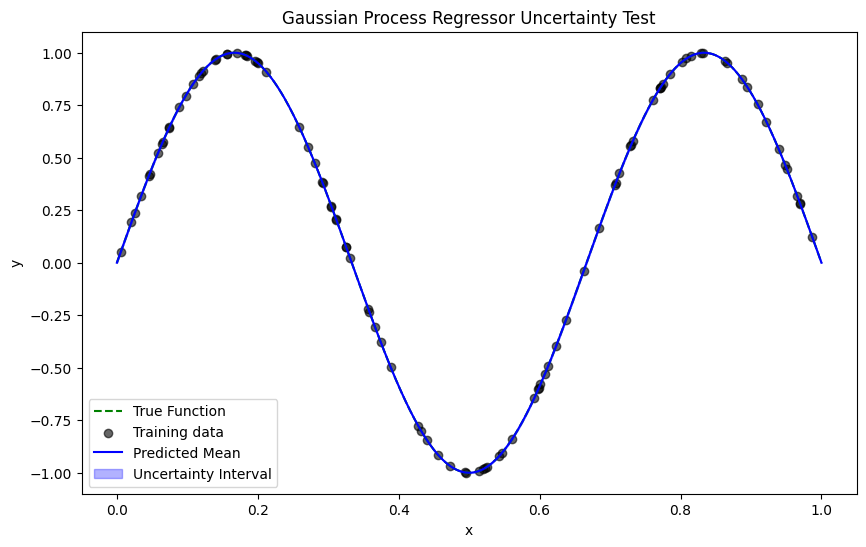

In [5]:
from uqregressors.bayesian.gaussian_process import GPRegressor
from sklearn.gaussian_process.kernels import RBF

gp_kwargs = {"normalize_y": True}
gpr = GPRegressor(kernel= RBF(length_scale=0.2, length_scale_bounds=(0.05, 1)), alpha=0.1, gp_kwargs=gp_kwargs)
gpr.fit(X_train, y_train)
gp_sol = gpr.predict(X_test)
plot_uncertainty_results(*gp_sol, "Gaussian Process Regressor")

## BBMM Gaussian Process

[Logger-25496] epoch=0, train_loss=1.0277092456817627
[Logger-25496] epoch=50, train_loss=-1.492130994796753
[Logger-25496] epoch=100, train_loss=-3.05782413482666
[Logger-25496] epoch=150, train_loss=-3.1835126876831055
[Logger-25496] epoch=200, train_loss=-3.202526807785034
[Logger-25496] epoch=250, train_loss=-3.21077299118042
[Logger-25496] epoch=300, train_loss=-3.215054512023926
[Logger-25496] epoch=350, train_loss=-3.217118740081787
[Logger-25496] epoch=400, train_loss=-3.2191617488861084
[Logger-25496] epoch=450, train_loss=-3.220369815826416
[Logger-25496] epoch=500, train_loss=-3.22139310836792
[Logger-25496] epoch=550, train_loss=-3.2223870754241943
[Logger-25496] epoch=600, train_loss=-3.222482204437256
[Logger-25496] epoch=650, train_loss=-3.2234184741973877
[Logger-25496] epoch=700, train_loss=-3.2234749794006348
[Logger-25496] epoch=750, train_loss=-3.223423719406128
[Logger-25496] epoch=800, train_loss=-3.223464012145996
[Logger-25496] epoch=850, train_loss=-3.224402666

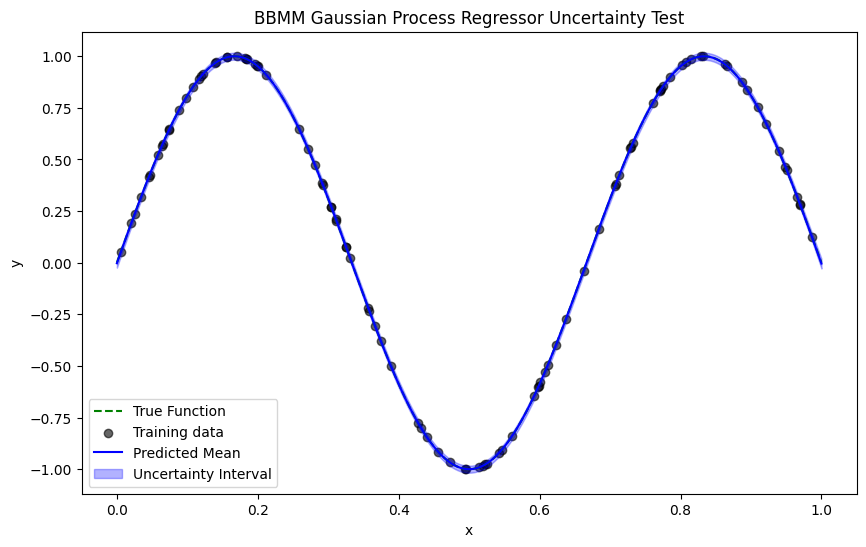

In [ ]:
from uqregressors.bayesian.bbmm_gp import BBMM_GP
import gpytorch

bbmm_gp = BBMM_GP(kernel=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), 
                           likelihood=gpytorch.likelihoods.GaussianLikelihood(), 
                           alpha = 0.1,
                           epochs=1000,
                           learning_rate=1e-1,
                           device="cpu",
                           use_wandb=False)

bbmm_gp.fit(X_train, y_train)
bbmm_gp_sol = bbmm_gp.predict(X_test)
plot_uncertainty_results(*bbmm_gp_sol, "BBMM Gaussian Process Regressor")

## Split Conformal Quantile Regression

[Logger-25496] epoch=0, train_loss=1.169694423675537


[Logger-25496] epoch=125, train_loss=0.0743483230471611
[Logger-25496] epoch=250, train_loss=0.031663116067647934
[Logger-25496] epoch=375, train_loss=0.013477731496095657
[Logger-25496] epoch=500, train_loss=0.01034313254058361
[Logger-25496] epoch=625, train_loss=0.006870959885418415
[Logger-25496] epoch=750, train_loss=0.01657646708190441
[Logger-25496] epoch=875, train_loss=0.009340195916593075
[Logger-25496] epoch=1000, train_loss=0.01717149093747139
[Logger-25496] epoch=1125, train_loss=0.008962220512330532
[Logger-25496] epoch=1250, train_loss=0.009794684126973152
[Logger-25496] epoch=1375, train_loss=0.007901121862232685
[Logger-25496] epoch=1500, train_loss=0.009677166119217873
[Logger-25496] epoch=1625, train_loss=0.014123340137302876
[Logger-25496] epoch=1750, train_loss=0.010461491532623768
[Logger-25496] epoch=1875, train_loss=0.0065198796801269054
[Logger-25496] epoch=2000, train_loss=0.003805586602538824
[Logger-25496] epoch=2125, train_loss=0.005542011000216007
[Logger-

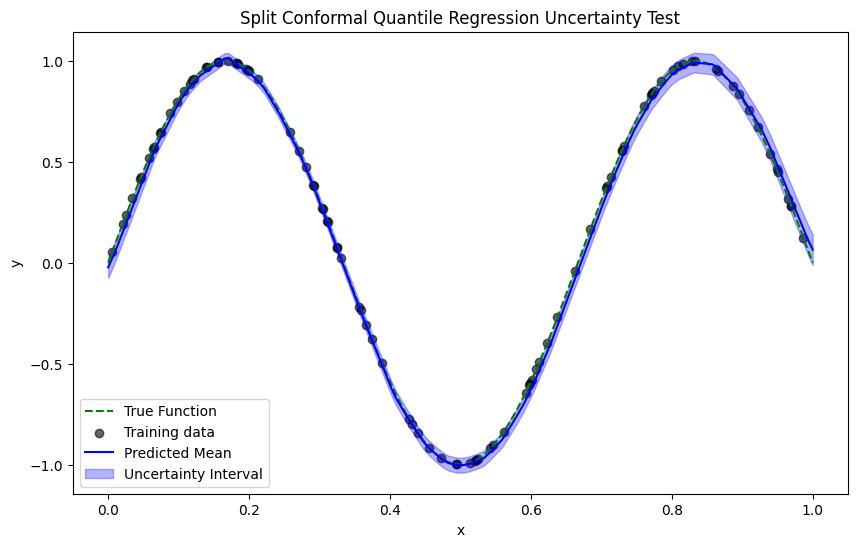

In [7]:
from uqregressors.conformal.conformal_split import ConformalQuantileRegressor 

cqr = ConformalQuantileRegressor(hidden_sizes = [100, 100], 
                                 cal_size=0.2, 
                                 alpha=0.1, 
                                 dropout=None,
                                 epochs=2500, 
                                 learning_rate=1e-3, 
                                 device="cpu", 
                                 use_wandb=False 
                                 )

cqr.fit(X_train, y_train)
cqr_sol = cqr.predict(X_test)

plot_uncertainty_results(*cqr_sol, "Split Conformal Quantile Regression")

## K-fold Conformal Quantile Regression 

[Estimator-0] epoch=0, train_loss=1.0754607915878296
[Estimator-0] epoch=125, train_loss=0.07459374517202377
[Estimator-0] epoch=250, train_loss=0.025703854858875275
[Estimator-0] epoch=375, train_loss=0.020214859396219254
[Estimator-0] epoch=500, train_loss=0.011477191001176834
[Estimator-0] epoch=625, train_loss=0.013292207382619381
[Estimator-0] epoch=750, train_loss=0.0068876431323587894
[Estimator-0] epoch=875, train_loss=0.0067116254940629005
[Estimator-0] epoch=1000, train_loss=0.00637077447026968
[Estimator-0] epoch=1125, train_loss=0.005537691991776228
[Estimator-0] epoch=1250, train_loss=0.009216155856847763
[Estimator-0] epoch=1375, train_loss=0.009718358516693115
[Estimator-0] epoch=1500, train_loss=0.006152849644422531
[Estimator-0] epoch=1625, train_loss=0.005562221631407738
[Estimator-0] epoch=1750, train_loss=0.0036510375794023275
[Estimator-0] epoch=1875, train_loss=0.010979962535202503
[Estimator-0] epoch=2000, train_loss=0.006514673121273518
[Estimator-0] epoch=2125,

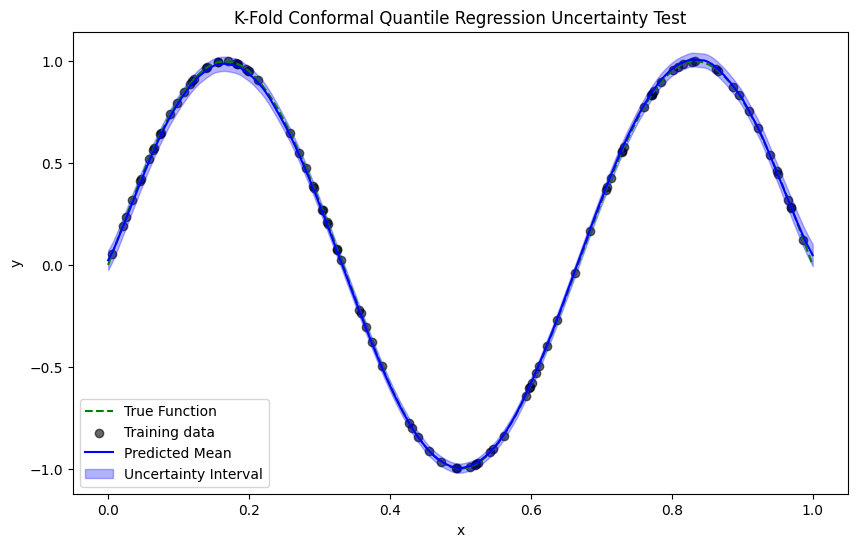

In [8]:
from uqregressors.conformal.k_fold_cqr import KFoldCQR
    
k_fold_cqr = KFoldCQR(n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,  # 90% confidence
    dropout=None,
    epochs=2500,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    n_jobs=1,
    use_wandb=False)

k_fold_cqr.fit(X_train, y_train)
k_fold_cqr_sol = k_fold_cqr.predict(X_test)

plot_uncertainty_results(*k_fold_cqr_sol, "K-Fold Conformal Quantile Regression")

## Normalized ConformalEns

[Estimator-0] epoch=0, train_loss=2.71669602394104
[Estimator-0] epoch=50, train_loss=0.12582141533493996
[Estimator-0] epoch=100, train_loss=0.018862311262637377
[Estimator-0] epoch=150, train_loss=0.005448776995763183
[Estimator-0] epoch=200, train_loss=0.0013853686687070876
[Estimator-0] epoch=250, train_loss=0.0009073450273717754
[Estimator-0] epoch=300, train_loss=0.00029428163543343544
[Estimator-0] epoch=350, train_loss=0.00048509575572097674
[Estimator-0] epoch=400, train_loss=0.00034054005664074793
[Estimator-0] epoch=450, train_loss=0.0003555370076355757
[Estimator-0] epoch=500, train_loss=0.00016698723266017623
[Estimator-0] epoch=550, train_loss=0.0004582343972288072
[Estimator-0] epoch=600, train_loss=0.00025136274052783847
[Estimator-0] epoch=650, train_loss=0.0002369810281379614
[Estimator-0] epoch=700, train_loss=0.00026644613353710156
[Estimator-0] epoch=750, train_loss=0.0004410572691995185
[Estimator-0] epoch=800, train_loss=7.825203829270322e-05
[Estimator-0] epoch=

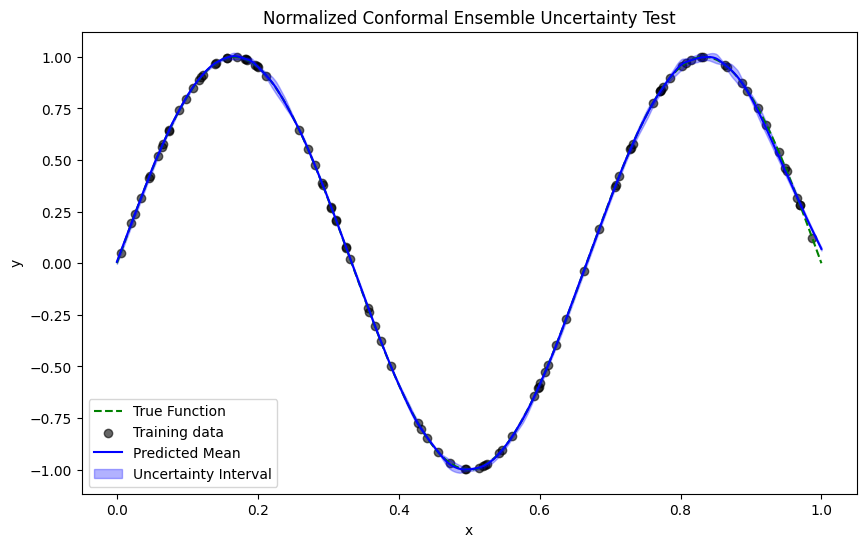

In [9]:
from uqregressors.conformal.conformal_ens import ConformalEnsRegressor

conformal_ens = ConformalEnsRegressor(n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,  # 90% confidence
    cal_size=0.2,
    epochs=1000,
    gamma=0, 
    dropout=None,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    n_jobs=1,
    use_wandb=False)

conformal_ens.fit(X_train, y_train)
conformal_ens_sol = conformal_ens.predict(X_test)

plot_uncertainty_results(*conformal_ens_sol, "Normalized Conformal Ensemble")

c:\Users\arsha\AppData\Local\hatch\env\virtual\uqregressors\pe5T5b9S\uqregressors\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\arsha\AppData\Local\hatch\env\virtual\uqregressors\pe5T5b9S\uqregressors\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


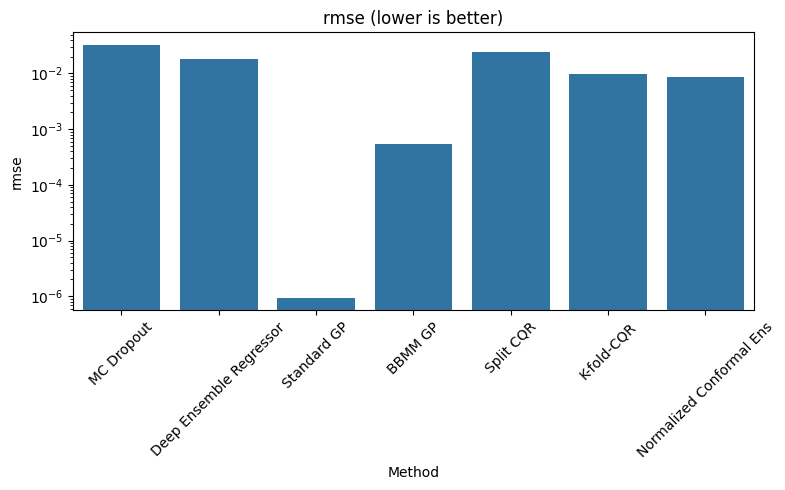

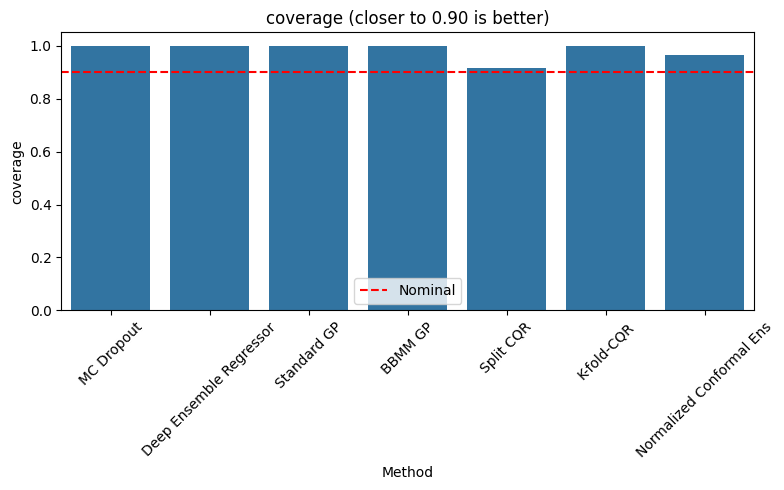

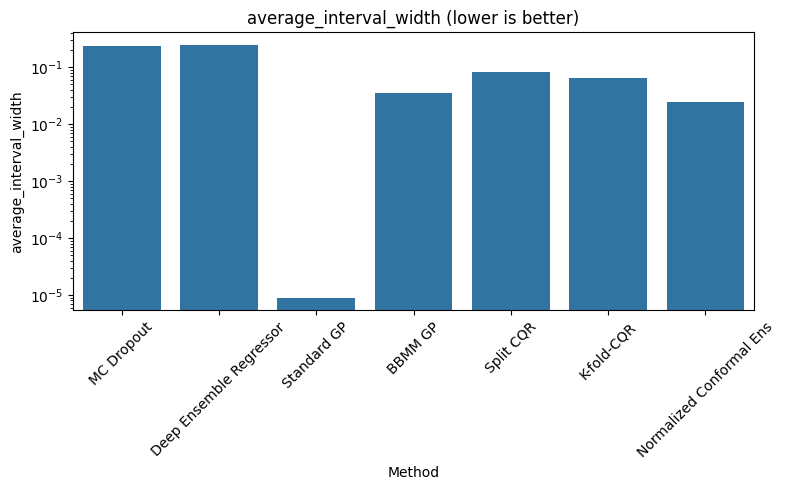

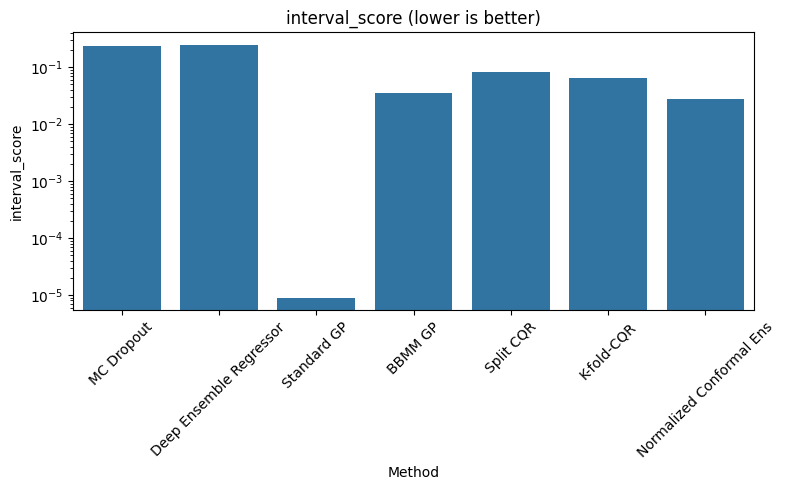

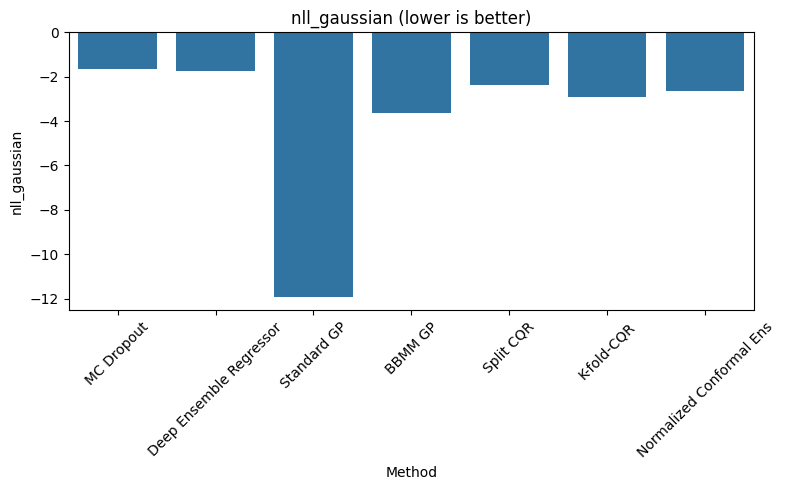

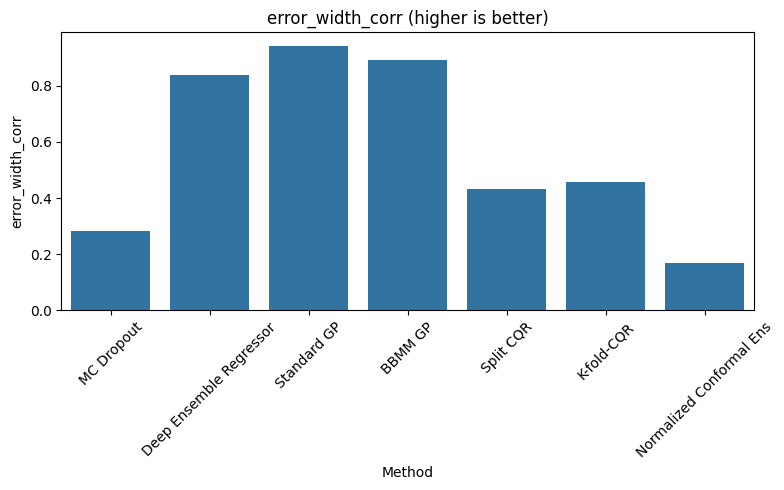

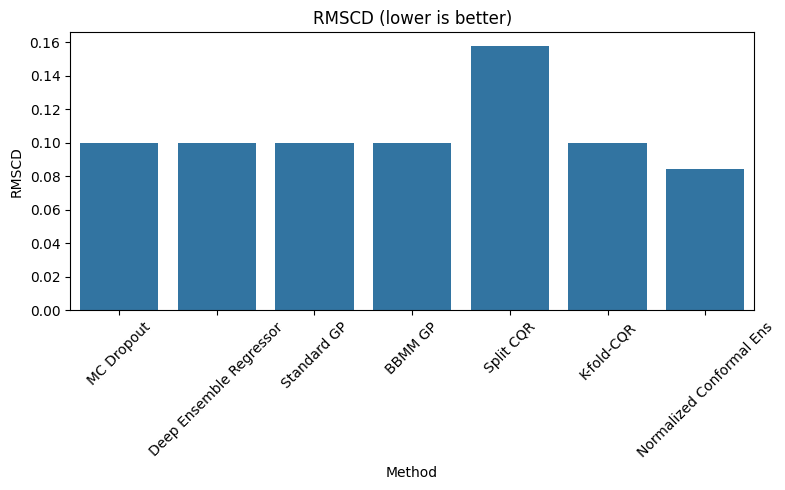

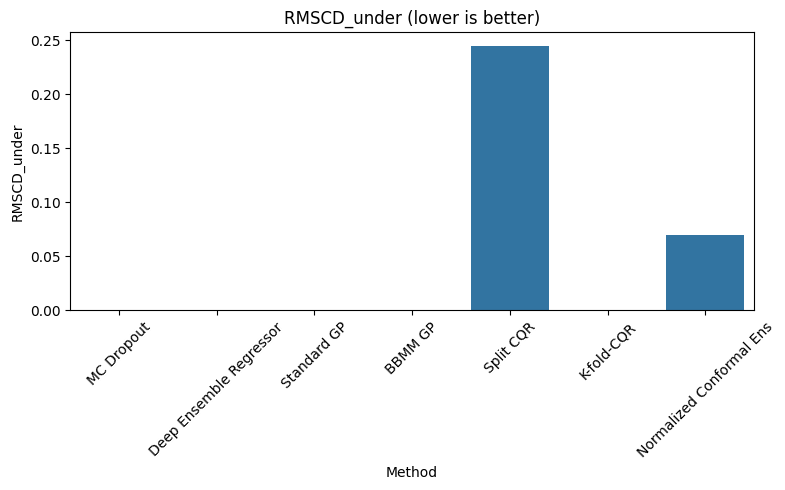

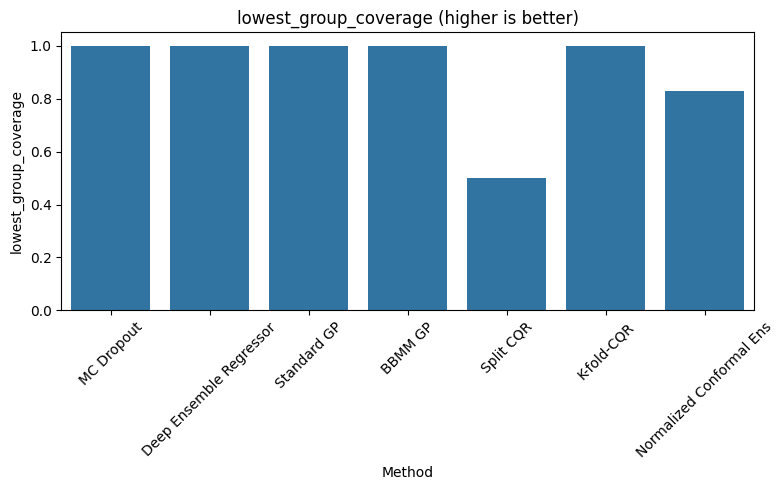

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from uqregressors.metrics.metrics import compute_all_metrics
alpha=0.1

sol_dict = {"MC Dropout": dropout_sol, 
            "Deep Ensemble Regressor": deep_ens_sol, 
            "Standard GP": gp_sol, 
            "BBMM GP": bbmm_gp_sol, 
            "Split CQR": cqr_sol, 
            "K-fold-CQR": k_fold_cqr_sol, 
            "Normalized Conformal Ens": conformal_ens_sol}

def evaluate_all_methods(sol_dict, y_true, alpha=0.1):
    rows = []
    for method, (mean, lower, upper) in sol_dict.items():
        metrics = compute_all_metrics(mean, lower, upper, y_true, alpha)
        metrics["method"] = method
        rows.append(metrics)
    return pd.DataFrame(rows)

def plot_metrics(df, alpha=0.1, log_metrics=None, figsize=(8, 5)):
    """
    Plots each metric in a separate subplot with appropriate annotations and log scales.

    Args:
        df: DataFrame with columns ["method", metric1, metric2, ...]
        alpha: Confidence level used for calculating coverage.
        log_metrics: List of metrics to plot on log scale.
        figsize: Base figure size for each subplot.
    """
    log_metrics = log_metrics or ["rmse", "interval_score", "average_interval_width"]
    metrics = [col for col in df.columns if col != "method"]
    
    # Helpful title annotations
    better_direction = {
        "rmse": "lower is better",
        "nll_gaussian": "lower is better",
        "interval_score": "lower is better",
        "coverage": "closer to {:.2f} is better".format(1 - alpha),
        "average_interval_width": "lower is better",
        "error_width_corr":"higher is better", 
        "RMSCD": "lower is better", 
        "RMSCD_under": "lower is better", 
        "lowest_group_coverage": "higher is better"
    }

    for metric in metrics:
        plt.figure(figsize=figsize)
        sns.barplot(data=df, x="method", y=metric)
        plt.xticks(rotation=45)
        
        # Set log scale if appropriate
        if metric in log_metrics:
            plt.yscale("log")

        # Add coverage reference line
        if metric == "coverage":
            plt.axhline(1 - alpha, color="red", linestyle="--", label="Nominal")
            plt.legend()

        title = f"{metric} ({better_direction.get(metric, '')})"
        plt.title(title)
        plt.ylabel(metric)
        plt.xlabel("Method")
        plt.tight_layout()
        plt.show()

metrics_df = evaluate_all_methods(sol_dict, y_true, alpha=0.1)
plot_metrics(metrics_df)

## Calibration Curves

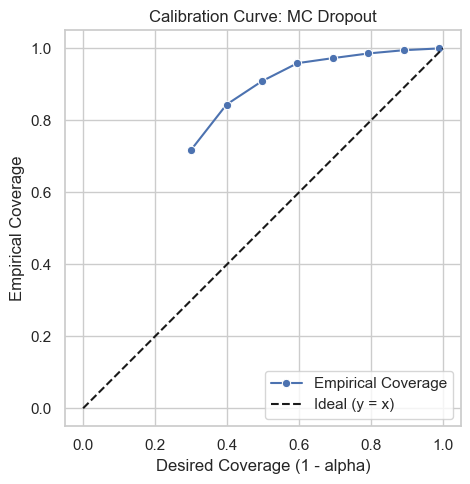

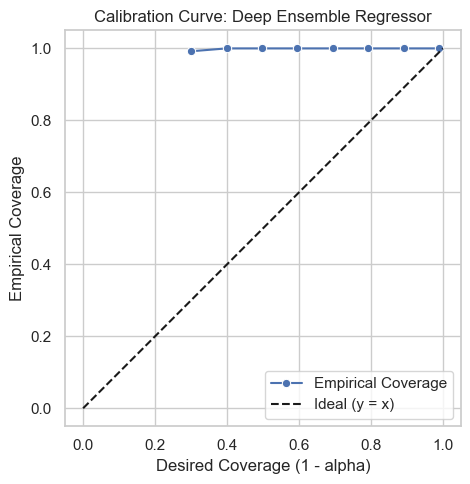

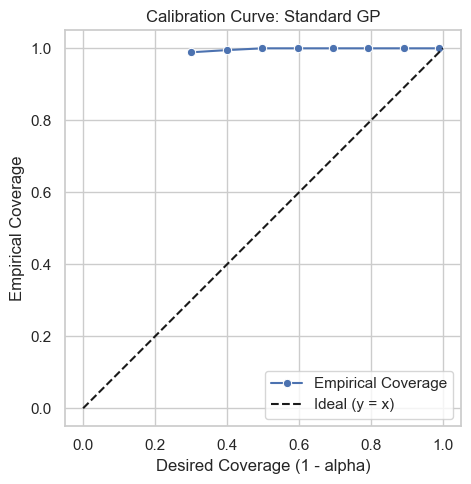

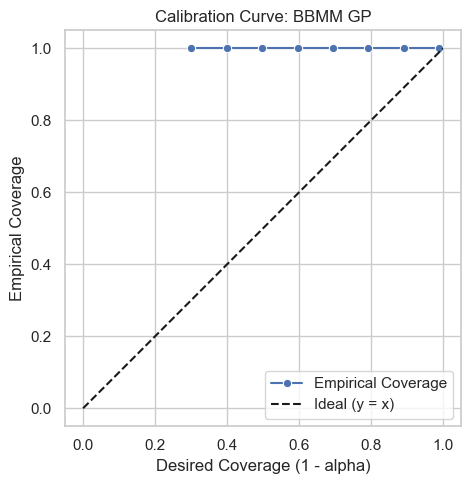

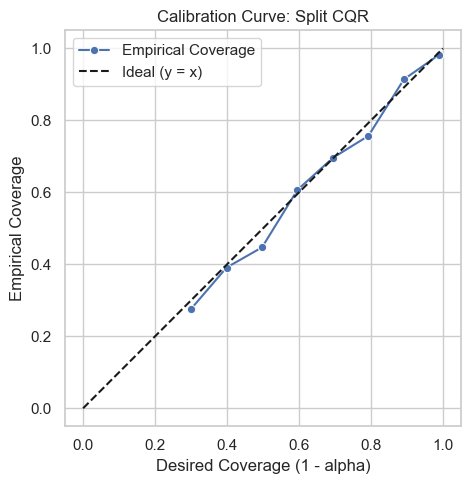

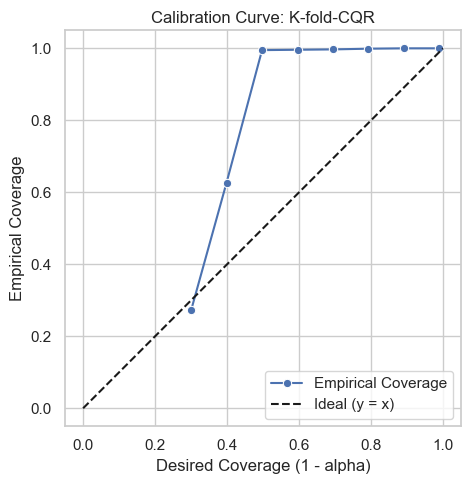

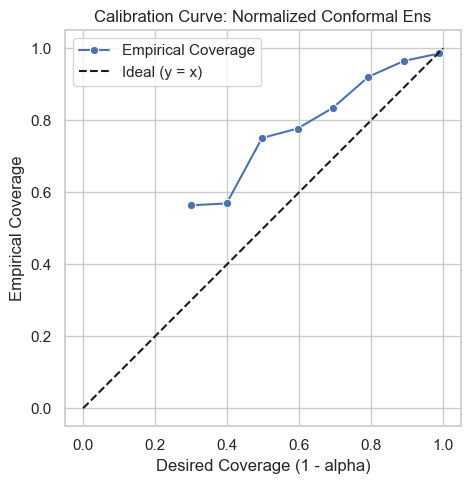

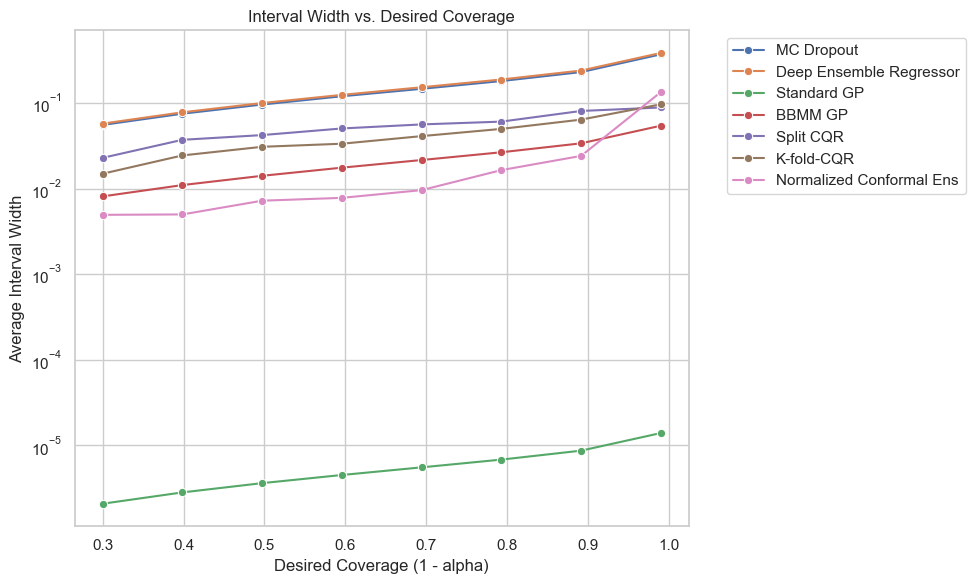

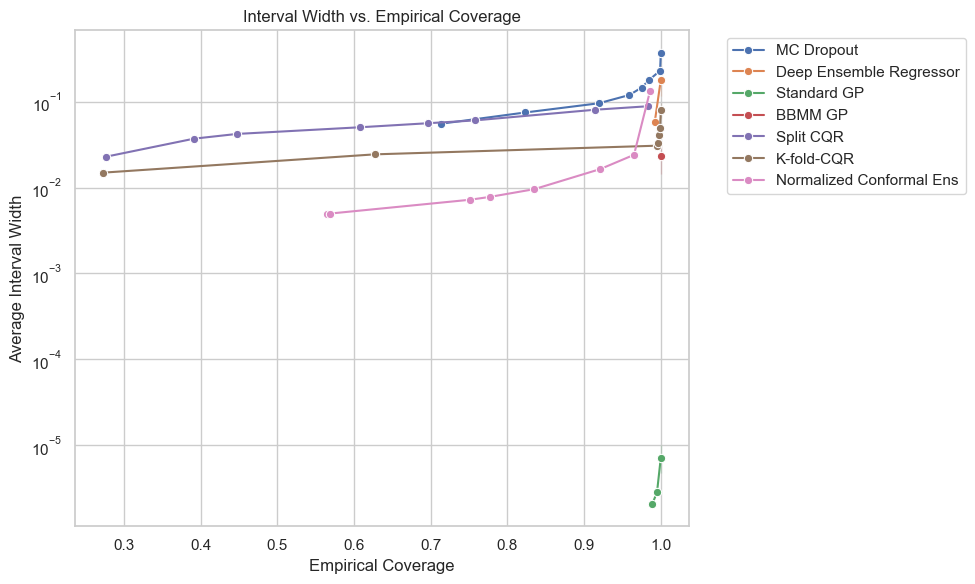

In [24]:
from uqregressors.metrics.metrics import coverage
from uqregressors.metrics.metrics import average_interval_width
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

model_dict = {"MC Dropout": dropout, 
            "Deep Ensemble Regressor": deep_ens, 
            "Standard GP": gpr, 
            "BBMM GP": bbmm_gp, 
            "Split CQR": cqr, 
            "K-fold-CQR": k_fold_cqr, 
            "Normalized Conformal Ens": conformal_ens}

# Set of alphas shared across models
n_alphas = 8
alphas = np.linspace(0.7, 0.01, n_alphas)
desired_coverage = 1 - alphas

# Dictionary to store interval widths per model
interval_widths_by_model = {}

# Main calibration curve and interval width computation
for model_name, model in model_dict.items():
    coverages = np.zeros(n_alphas)
    interval_widths = np.zeros(n_alphas)
    for i, alpha in enumerate(alphas):
        model.alpha = alpha
        mean, lower, upper = model.predict(X_test)
        coverages[i] = coverage(lower, upper, y_true)
        interval_widths[i] = average_interval_width(lower, upper)

    # Plot calibration curve
    plt.figure(figsize=(8, 5))
    sns.set_theme(style='whitegrid')
    sns.lineplot(x=desired_coverage, y=coverages, marker='o', label='Empirical Coverage')
    plt.plot([0, 1], [0, 1], 'k--', label='Ideal (y = x)')
    plt.xlabel('Desired Coverage (1 - alpha)')
    plt.ylabel('Empirical Coverage')
    plt.title(f'Calibration Curve: {model_name}')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

    # Store widths for combined plot
    interval_widths_by_model[model_name] = interval_widths

# Plot average interval width for all models on same plot
plt.figure(figsize=(10, 6))
for model_name, widths in interval_widths_by_model.items():
    sns.lineplot(x=desired_coverage, y=widths, marker='o', label=model_name)

plt.xlabel('Desired Coverage (1 - alpha)')
plt.ylabel('Average Interval Width')
plt.title('Interval Width vs. Desired Coverage')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside if crowded
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for model_name in interval_widths_by_model:
    widths = interval_widths_by_model[model_name]
    model = model_dict[model_name]
    model_coverages = []

    # Recompute or reuse empirical coverages
    for i, alpha in enumerate(alphas):
        model.alpha = alpha
        mean, lower, upper = model.predict(X_test)
        model_coverages.append(coverage(lower, upper, y_true))

    sns.lineplot(x=model_coverages, y=widths, marker='o', label=model_name)

plt.xlabel('Empirical Coverage')
plt.ylabel('Average Interval Width')
plt.title('Interval Width vs. Empirical Coverage')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log')
plt.tight_layout()
plt.show()

